In [1]:
import os
from google.colab import drive

drive.mount('/content/gdrive/')


Mounted at /content/gdrive/


In [2]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import Input, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import train_test_split

import tensorflow_hub as hub

In [3]:
# Getting names of the classes we have
data_directory = pathlib.Path('/content/gdrive/MyDrive/dataset_pizza/')
class_names = [item.name for item in data_directory.glob('*')][:2]
print(class_names)

['pizza', 'not_pizza']


In [4]:
not_pizza_dir = '/content/gdrive/MyDrive/dataset_pizza/not_pizza'
pizza_dir = '/content/gdrive/MyDrive/dataset_pizza/pizza'
data_dir = '/content/gdrive/MyDrive/dataset_pizza/'

In [5]:
num_pizza_images = len(os.listdir(pizza_dir))
non_pizza_images = len(os.listdir(not_pizza_dir))
print(f'Number of Pizza images: {num_pizza_images}')
print(f'Number of Non-Pizza images: {non_pizza_images}')

Number of Pizza images: 983
Number of Non-Pizza images: 983


In [6]:
# Defining data generator withour Data Augmentation
data_gen = ImageDataGenerator(rescale = 1/255.,
                              validation_split = 0.1,
                              zoom_range = 0.2,
                              horizontal_flip= True,
                              rotation_range = 20,
                              width_shift_range=0.2,
                              height_shift_range=0.2)

train_data = data_gen.flow_from_directory(data_dir,
                                          target_size = (224, 224),
                                          batch_size = 32,
                                          subset = 'training',
                                          class_mode = 'binary')
val_data = data_gen.flow_from_directory(data_dir,
                                        target_size = (224, 224),
                                        batch_size = 32,
                                        subset = 'validation',
                                        class_mode = 'binary')

Found 1770 images belonging to 2 classes.
Found 196 images belonging to 2 classes.


In [7]:
def plot_random_images():
    """
    Plots 20 Random Images from the dataset
    """
    images, labels = train_data.next()
    labels = labels.astype('int32')
    labels = 1 - labels  # Reversing the labels
    i = 1

    plt.figure(figsize=(10, 5))

    for image, label in zip(images, labels):
        plt.subplot(4, 5, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
        i += 1
        if i == 21:
            break

    plt.tight_layout()
    plt.show()


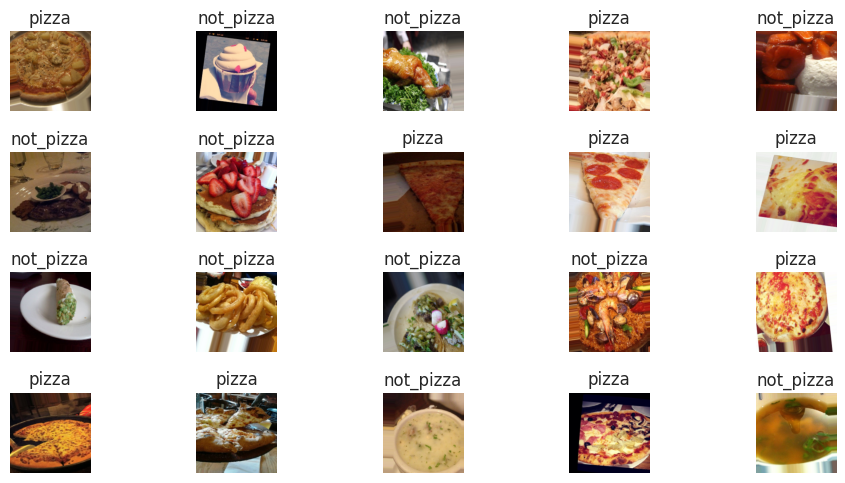

In [8]:
plot_random_images()

In [9]:
model_1 = Sequential([
    Input(shape = (224, 224, 3)),
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'),
    MaxPool2D(pool_size = 2), # It will reduce the number of features by half
    Conv2D(filters = 32, kernel_size =2, padding = 'valid', activation = 'relu'),
    MaxPool2D(pool_size = 2),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])

model_1.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(learning_rate = 0.001),
                metrics = ['accuracy'])

history_1 = model_1.fit(train_data,
                        epochs= 50,
                        steps_per_epoch = len(train_data),
                        validation_data = val_data,
                        validation_steps = len(val_data))

Epoch 1/50
56/56 [==============================] - 418s 7s/step - loss: 0.8225 - accuracy: 0.5661 - val_loss: 0.6208 - val_accuracy: 0.6735
Epoch 2/50
56/56 [==============================] - 121s 2s/step - loss: 0.6318 - accuracy: 0.6373 - val_loss: 0.5780 - val_accuracy: 0.7347
Epoch 3/50
56/56 [==============================] - 131s 2s/step - loss: 0.5977 - accuracy: 0.6774 - val_loss: 0.5868 - val_accuracy: 0.7245
Epoch 4/50
56/56 [==============================] - 119s 2s/step - loss: 0.5854 - accuracy: 0.7034 - val_loss: 0.5531 - val_accuracy: 0.7602
Epoch 5/50
56/56 [==============================] - 121s 2s/step - loss: 0.5739 - accuracy: 0.7113 - val_loss: 0.6313 - val_accuracy: 0.6276
Epoch 6/50
56/56 [==============================] - 121s 2s/step - loss: 0.6034 - accuracy: 0.6814 - val_loss: 0.5675 - val_accuracy: 0.7449
Epoch 7/50
56/56 [==============================] - 122s 2s/step - loss: 0.5645 - accuracy: 0.7243 - val_loss: 0.5125 - val_accuracy: 0.7704
Epoch 8/50
56

In [10]:
# Plot the validation and training data separately
def plot_loss_curves(history):
    """
    Plots the curves of both loss and accuracy
    """

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(loss))

    fig, ax = plt.subplots(1, 2, figsize = (20, 5))

    # Plotting loss
    ax1 = sns.lineplot(x = epochs, y = loss, label='Training Loss', ax= ax[0])
    ax1 = sns.lineplot(x = epochs, y = val_loss, label='Validation Loss', ax= ax[0])
    ax1.set(title = 'Loss', xlabel = 'Epochs')

    # Plot accuracy
    ax2 = sns.lineplot(x = epochs, y = accuracy, label='Training Accuracy', ax= ax[1])
    ax2 = sns.lineplot(x = epochs, y = val_accuracy, label='Validation Accuracy', ax=ax[1])
    ax2.set(title = 'Accuracy', xlabel = 'Epochs')

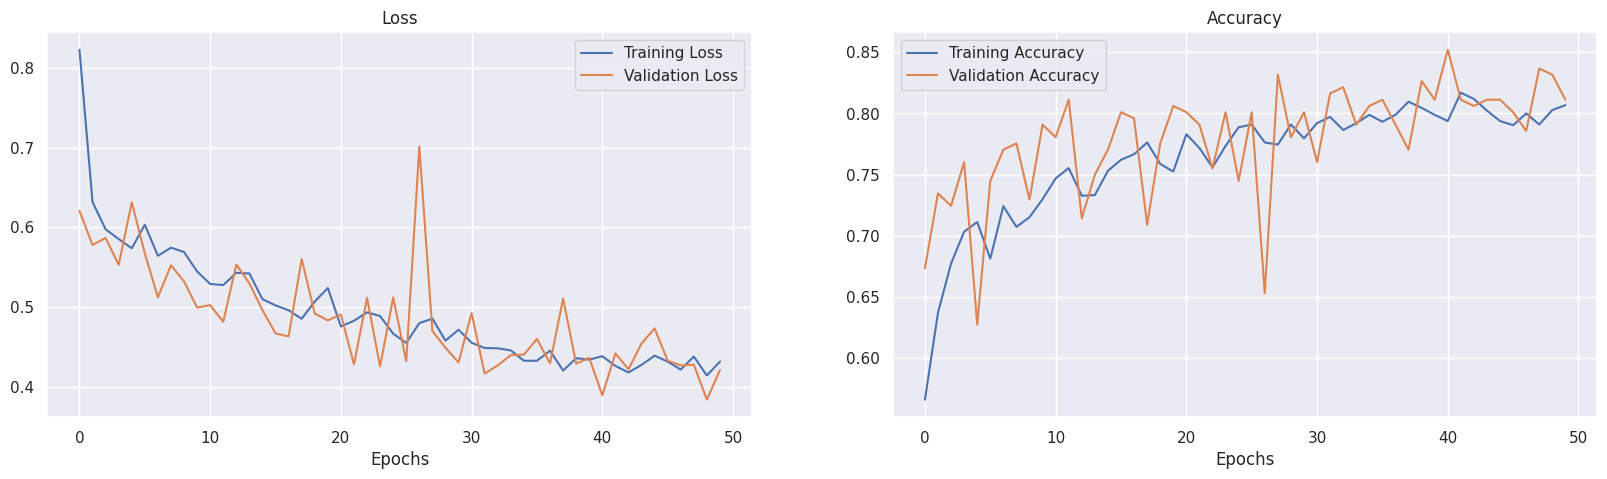

In [11]:
plot_loss_curves(history_1)

In [19]:
# Defining data generator with Data Augmentation
data_gen_augmented = ImageDataGenerator(rescale = 1/255.,
                                        validation_split = 0.1,
                                        zoom_range = 0.2,
                                        horizontal_flip= True,
                                        rotation_range = 20,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2)

print('Augmented training Images:')
train_data_augmented = data_gen_augmented.flow_from_directory(data_dir,
                                                              target_size = (224, 224),
                                                              batch_size = 64,
                                                              subset = 'training',
                                                              class_mode = 'binary')

print('Augmented Validation Images:')
val_data_augmented = data_gen_augmented.flow_from_directory(data_dir,
                                        target_size = (224, 224),
                                        batch_size = 64,
                                        subset = 'validation',
                                        class_mode = 'binary')

Augmented training Images:
Found 1770 images belonging to 2 classes.
Augmented Validation Images:
Found 196 images belonging to 2 classes.


In [20]:
model_2 = Sequential([
    Input(shape = (224, 224, 3)),
    Conv2D(filters = 10, kernel_size = 2, padding = 'valid', activation = 'relu'),
    MaxPool2D(pool_size = 2),
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'),
    MaxPool2D(pool_size = 2),
    Conv2D(filters = 64, kernel_size = 2, padding = 'valid', activation = 'relu'),
    MaxPool2D(pool_size = 2),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])

model_2.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(learning_rate = 0.0001),
                metrics = ['accuracy'])

history_2 = model_2.fit(train_data_augmented,
                        epochs= 100,
                        steps_per_epoch = len(train_data_augmented),
                        validation_data = val_data_augmented,
                        validation_steps = len(val_data_augmented))

Epoch 1/100
28/28 [==============================] - 101s 3s/step - loss: 0.6869 - accuracy: 0.5424 - val_loss: 0.6732 - val_accuracy: 0.6786
Epoch 2/100
28/28 [==============================] - 100s 4s/step - loss: 0.6638 - accuracy: 0.6362 - val_loss: 0.6505 - val_accuracy: 0.6429
Epoch 3/100
28/28 [==============================] - 99s 4s/step - loss: 0.6419 - accuracy: 0.6695 - val_loss: 0.6255 - val_accuracy: 0.6837
Epoch 4/100
28/28 [==============================] - 99s 4s/step - loss: 0.6183 - accuracy: 0.6633 - val_loss: 0.6005 - val_accuracy: 0.7398
Epoch 5/100
28/28 [==============================] - 98s 3s/step - loss: 0.6048 - accuracy: 0.6887 - val_loss: 0.5834 - val_accuracy: 0.7296
Epoch 6/100
28/28 [==============================] - 94s 3s/step - loss: 0.6083 - accuracy: 0.6712 - val_loss: 0.5834 - val_accuracy: 0.7347
Epoch 7/100
28/28 [==============================] - 99s 4s/step - loss: 0.6108 - accuracy: 0.6808 - val_loss: 0.5786 - val_accuracy: 0.7245
Epoch 8/100

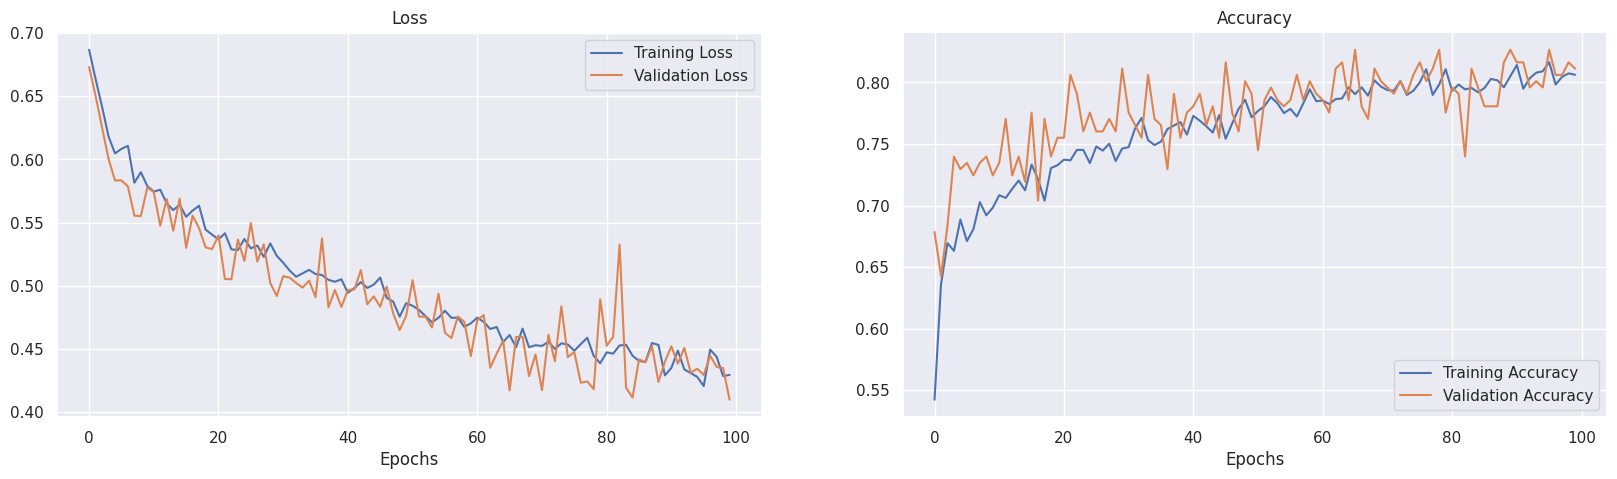

In [21]:
plot_loss_curves(history_2)